<h1>Normalized wave height as a function of cross shore location</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import io
import cftime
import netCDF4 as nc
import pickle
import glob
import scipy.stats as st
from PyAstronomy import pyaC
import cmocean
import cftime
from scipy.stats import gaussian_kde
import scipy.stats
%matplotlib widget

In [2]:
# Compute Distribution of Indicudla waves from all microSWIFTs using zero crossing algorithm 
def waveHeightDist(mission_nc):
    # Load in Mission Data
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    # Get list of all microSWIFTs on the mission
    microSWIFTs_on_mission = list(mission_dataset.groups.keys())

    # Iniialize the arrays to store the wave height and locations in 
    wave_heights = []
    wave_x_locs = []
    wave_y_locs = []

    # For Each microSWIFT sea surface elevation, find 45 zero crossings of the sea surface elevation
    for microSWIFT in microSWIFTs_on_mission:
        eta = mission_dataset[microSWIFT]['eta'][:] 
        x = mission_dataset[microSWIFT]['xFRF'][:]
        y = mission_dataset[microSWIFT]['yFRF'][:]
        time = mission_dataset['time'][:]
        cross_time, cross_ind = pyaC.zerocross1d(time, eta, getIndices=True)

        # Get every other index so we have zero crossings in the same direction 
        wave_inds = cross_ind[::2]

        # # Plot the cross Locations
        # fig, ax = plt.subplots()
        # ax.plot(eta)
        # for ind in wave_inds:
        #     ax.axvline(ind, -3, 3, color='k', linestyle='dashed')

        # Compute Wave Height from each set of indices
        for n in np.arange(np.size(wave_inds)-1):
            # Get 45 elevation heights in between each zero crossing index
            eta_in_wave = eta[wave_inds[n]:wave_inds[n+1]]
            x_in_wave = x[wave_inds[n]:wave_inds[n+1]]
            y_in_wave = y[wave_inds[n]:wave_inds[n+1]]

            # Check if there are any values otherwise skip
            if np.size(eta_in_wave) > 0: 
                # Add the compute wave height
                wave_height = np.max(eta_in_wave)- np.min(eta_in_wave)
                # if np.isnan(wave_height)==False and wave_height <= 8:
                if np.isnan(wave_height)==False:
                    wave_heights.append(wave_height)
                    # Add the computed average location of the wave
                    wave_x_locs.append(np.mean(x_in_wave))
                    wave_y_locs.append(np.mean(y_in_wave))
            else: 
                continue
    mission_dataset.close()

    return wave_heights, wave_x_locs, wave_y_locs

def interpDepth(x,y):
    # Load in bathymetry Data and find location of each 
    bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
    elevation_dem = bathy_data['elevation'][0,:,:]
    bathy_xFRF = bathy_data['xFRF'][:]
    bathy_yFRF = bathy_data['yFRF'][:]
    bathy_f = interpolate.interp2d(bathy_xFRF, bathy_yFRF, elevation_dem)

    # Depth of each wave
    depth = []
    for n in np.arange(len(x)):
        depth.append(np.squeeze(bathy_f(x[n], y[n])).item())
    return depth 

def computeSigWaveHeight(wave_heights):
    # Sort wave heights
    wave_height_sort = np.sort(wave_heights)

    # Get Top 1/3rd of wave heights
    top_third_waves = wave_height_sort[-(len(wave_heights)//3):]

    # Average Top 1/3rd of wave heights
    Hs = np.mean(top_third_waves)

    return Hs

def normalizeWaveHeightandCrossShoreDist(wave_height, mission_time, wave_depth, wave_x_locs, wave_y_locs, Hs):
    # Find cross shore location of Depth where surfzone is expected to start
    gamma = 0.5
    depth_surf_zone = Hs/gamma
    bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
    elevation_dem = bathy_data['elevation'][0,:,:]
    bathy_xFRF = bathy_data['xFRF'][:]
    bathy_yFRF = bathy_data['yFRF'][:]
    bathy_data.close() 
    
    # Adjust the Bathy by mean water level to find average profile
    waterLevel_dataset = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc')
    waterLevel_in_mission = np.interp(mission_time, waterLevel_dataset['time'][:], waterLevel_dataset['waterLevel'][:])
    depth_dem = elevation_dem + waterLevel_in_mission
    along_shore_avg_depth = np.mean(depth_dem, axis=0)
    surf_zone_width = np.interp(depth_surf_zone, along_shore_avg_depth, bathy_xFRF)

    wave_x_loc_norm = []
    wave_height_norm = []
    for n in np.arange(len(wave_height)):
        if (wave_x_locs[n] > np.min(bathy_xFRF) or wave_x_locs[n] < np.max(bathy_xFRF)) and (wave_y_locs[n] > np.min(bathy_yFRF) or wave_y_locs[n] < np.max(bathy_yFRF)):
            wave_height_norm_indiv = wave_height[n]/np.abs(wave_depth[n])
            if np.isnan(wave_height_norm_indiv)==False:
                wave_height_norm.append(wave_height_norm_indiv)
                wave_x_loc_norm.append(wave_x_locs[n]/surf_zone_width)

    return wave_height_norm, wave_x_loc_norm 


def processMissionWaves(mission_nc):
    
    # Get Distribution of Wave Heights and Locations
    wave_heights, wave_x_locs, wave_y_locs = waveHeightDist(mission_nc)

    # Compute Depth from each location
    wave_depth = interpDepth(wave_x_locs, wave_y_locs)

    # Compute Significant Wave Height
    Hs = computeSigWaveHeight(wave_heights)

    # Mission Time 
    mission_dataset = nc.Dataset(mission_nc, mode='r')
    median_time = np.median(mission_dataset['time'][:])
    mission_time = cftime.num2pydate(median_time, units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
    mission_dataset.close()
    
    # Normalize Wave Heights
    wave_height_norm, wave_x_locs_norm = normalizeWaveHeightandCrossShoreDist(wave_heights, median_time, wave_depth, wave_x_locs, wave_y_locs, Hs)

    # # Plot Distribution of Wave Heights 
    # fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), ncols=3)
    # # Plot Average Location of Each Wave on Bathymetry
    # bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
    # bathy_dataset = nc.Dataset(bathy_file)
    # # Create grid from coordinates
    # xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
    # bathy = bathy_dataset['elevation'][0,:,:]
    # im =ax1.contourf(xFRF_grid, yFRF_grid, bathy, cmap=cmocean.cm.deep_r)
    # cbar_bathy = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, location='top', orientation='horizontal')
    # cbar_bathy.ax.set_xlabel('Elevation, z [m]')
    # ax1.scatter(wave_x_locs, wave_y_locs, color='r', s=1, label='Average Location of Individual Waves')
    # ax1.legend()
    # ax1.set_xlabel('Cross Shore Location, x [m]')
    # ax1.set_ylabel('Along Shore Location, y [m]')

    # # Plot distribution of Wave Heights
    # ax2.hist(wave_heights, bins=50, density=True, label='Num Waves: {0:.0f}, Hs: {1:.2f} m'.format(len(wave_heights), Hs))
    # ax2.set_xlabel('Wave Height [m]')
    # ax2.set_ylabel('Probability Density [-]')
    # ax2.legend()

    # # Plot Normalized Wave Height versus cross shore location
    # x = wave_x_locs_norm
    # y = wave_height_norm
    # if len(x) > 0 and len(y) > 0:
    #     xy = np.vstack([x,y])
    #     z = gaussian_kde(xy)(xy)
    #     z = z/z.size
    #     scatter = ax3.scatter(x, y, c=z, cmap='plasma')
    #     cbar_dense = fig.colorbar(scatter, ax=ax3)
    #     cbar_dense.ax.set_ylabel('Probability Density')
    #     ax3.hlines(y=np.nanmean(wave_height_norm), xmin=0, xmax=1, linewidth=2, color='r', label='Average H/d: {0:.2f}'.format(np.nanmean(wave_height_norm)))
    #     ax3.set_xlim(0, np.max(wave_x_locs_norm)+0.2)
    #     ax3.set_ylim(0, np.max(wave_height_norm)+1)
    #     ax3.set_xlabel('Normalized Cross Shore Distance, x/$L_{sz}$ [-]')
    #     ax3.set_ylabel('Depth Normalized Wave Height,H/d [-]')
    #     ax3.legend()

    #     # Save the Figure 
    #     fig.savefig('./Figures/processedWaves_mission_{}.png'.format(mission_nc[-5:-3]))
        
    return wave_heights, wave_height_norm, Hs, wave_depth, wave_x_locs, wave_x_locs_norm, wave_y_locs, mission_time


In [14]:
# Get Distribution of Wave Heights and Locations
mission_list = glob.glob('../microSWIFT_data/cleanedDataset/mission_*.nc')
# Remove mission 51 and 52 from the mission list since they are valuable for other analysis on breaking identification but not general analysis due to being thrown so much 
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_27.nc')
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_30.nc')
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_51.nc')
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_52.nc')

# Initialize 45 variables 
wave_heights_all = []
wave_height_norm_all = []
Hs_all = []
wave_depth_all = []
wave_x_locs_all = []
wave_x_locs_norm_all = []
wave_y_locs_all = []
mission_time_all = []

for mission_nc in mission_list:
    wave_heights, wave_height_norm, Hs, wave_depth, wave_x_locs, wave_x_locs_norm, wave_y_locs, mission_time = processMissionWaves(mission_nc)

    if len(wave_heights) > 0: 
        # Append each variable to the overall datasets
        wave_heights_all.append(wave_heights)
        wave_height_norm_all.append(wave_height_norm)
        Hs_all.append(Hs)
        wave_depth_all.append(wave_depth)
        wave_x_locs_all.append(wave_x_locs)
        wave_x_locs_norm_all.append(wave_x_locs_norm)
        wave_y_locs_all.append(wave_y_locs)
        mission_time_all.append(mission_time)
    
# Flatten and Concatenate Lists
wave_heights_all = np.concatenate(wave_heights_all).flat
wave_height_norm_all = np.concatenate(wave_height_norm_all).flat
wave_x_locs_all = np.concatenate(wave_x_locs_all).flat
wave_x_locs_norm_all = np.concatenate(wave_x_locs_norm_all).flat
wave_y_locs_all = np.concatenate(wave_y_locs_all).flat

/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-4.708400587263721e-08


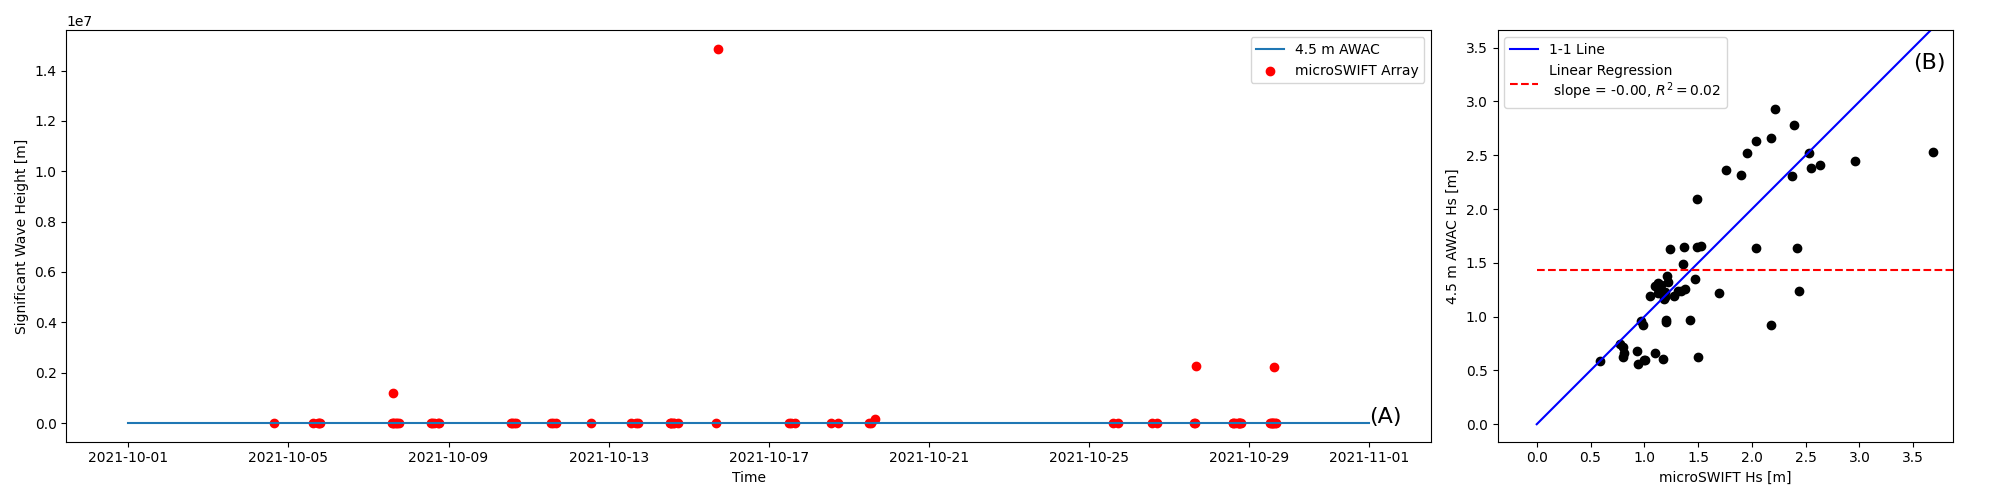

In [15]:
# Plot Hs as a function of time and compare to AWAC for further verification
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'], units=awac_data['time'].units, calendar=awac_data['time'].calendar)

# Compare the Significant wave heights between AWAC and microSWIFT arrays
mission_time_nums = nc.date2num(mission_time_all, units=awac_data['time'].units, calendar=awac_data['time'].calendar)
awac_hs_interp = np.interp(mission_time_nums, awac_data['time'][:], awac_data['waveHs'][:])

# Compute linear regression between the AWAC and microSWIFT Hs
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Hs_all, awac_hs_interp)
print(slope)

# Plot the AWAC and microSWIFT Hs values
fig_hs, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2, gridspec_kw={'width_ratios': [3, 1]})
# Time series
ax1.scatter(mission_time_all, Hs_all, color='r', label='microSWIFT Array')
ax1.plot(awac_time, awac_data['waveHs'][:], label='4.5 m AWAC')
ax1.set_xlabel('Time')
ax1.set_ylabel('Significant Wave Height [m]')
ax1.annotate('(A)', (awac_time[-1], 2.8), color='k', fontsize=16)
ax1.legend()

# Scatter plot
ax2.scatter(Hs_all, awac_hs_interp, color='k')
ax2.set_xlabel('microSWIFT Hs [m]')
ax2.set_ylabel('4.5 m AWAC Hs [m]')
ax2.axis('equal')
x = np.linspace(0, 4.5)
y = slope * x + intercept
ax2.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax2.plot(x, y, color='r', linestyle='dashed', label='Linear Regression \n slope = {0:.2f}, $R^2 = {1:.2f}$'.format(slope, r_value**2))
ax2.annotate('(B)', (3.5, 3.3), color='k', fontsize=16)
ax2.set_xlim(0,3.5)
ax2.set_ylim(0,3.5)
ax2.legend()
fig_hs.tight_layout()
fig_hs.savefig('./Figures/Hs_comparison.png')


In [5]:
# Get Distribution of Wave Heights and Locations
mission_list = glob.glob('../microSWIFT_data/cleanedDataset/mission_*.nc')
# Remove mission 51 and 52 from the mission list since they are valuable for other analysis on breaking identification but not general analysis due to being thrown so much 
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_27.nc')
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_51.nc')
mission_list.remove('../microSWIFT_data/cleanedDataset/mission_52.nc')

# Initialize all variables 
wave_heights_45 = []
wave_height_norm_45 = []
wave_depth_45 = []
wave_x_locs_45 = []
wave_x_locs_norm_45 = []
wave_y_locs_45 = []
mission_time_45 = []

for mission_nc in mission_list:
    wave_heights, wave_height_norm, Hs, wave_depth, wave_x_locs, wave_x_locs_norm, wave_y_locs, mission_time = processMissionWaves(mission_nc)

    wave_heights_in_45_mission = []
    wave_x_locs_in_45_mission = []
    wave_y_locs_in_45_mission = []

    for n in np.arange(len(wave_depth)):
        if wave_depth[n] > -5 and wave_depth[n] < -4 and ~np.isnan(wave_heights[n]):
            wave_heights_in_45_mission.append(wave_heights[n])
            wave_x_locs_in_45_mission.append(wave_x_locs[n])
            wave_y_locs_in_45_mission.append(wave_y_locs[n])
        else:
            continue
            
    if np.count_nonzero(~np.isnan(wave_heights_in_45_mission)) > 30: 
        wave_heights_45.append(wave_heights_in_45_mission)
        wave_x_locs_45.append(wave_x_locs_in_45_mission)
        wave_y_locs_45.append(wave_y_locs_in_45_mission)
        mission_time_45.append(mission_time)

    else:
        continue
    
# Compute Significant wave height from each distribution
Hs_45 = []
for waves in wave_heights_45:
    Hs_45.append(computeSigWaveHeight(waves))

# Flatten and Concatenate Lists
wave_heights_45 = np.concatenate(wave_heights_45).flat
wave_x_locs_45 = np.concatenate(wave_x_locs_45).flat
wave_y_locs_45 = np.concatenate(wave_y_locs_45).flat

/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


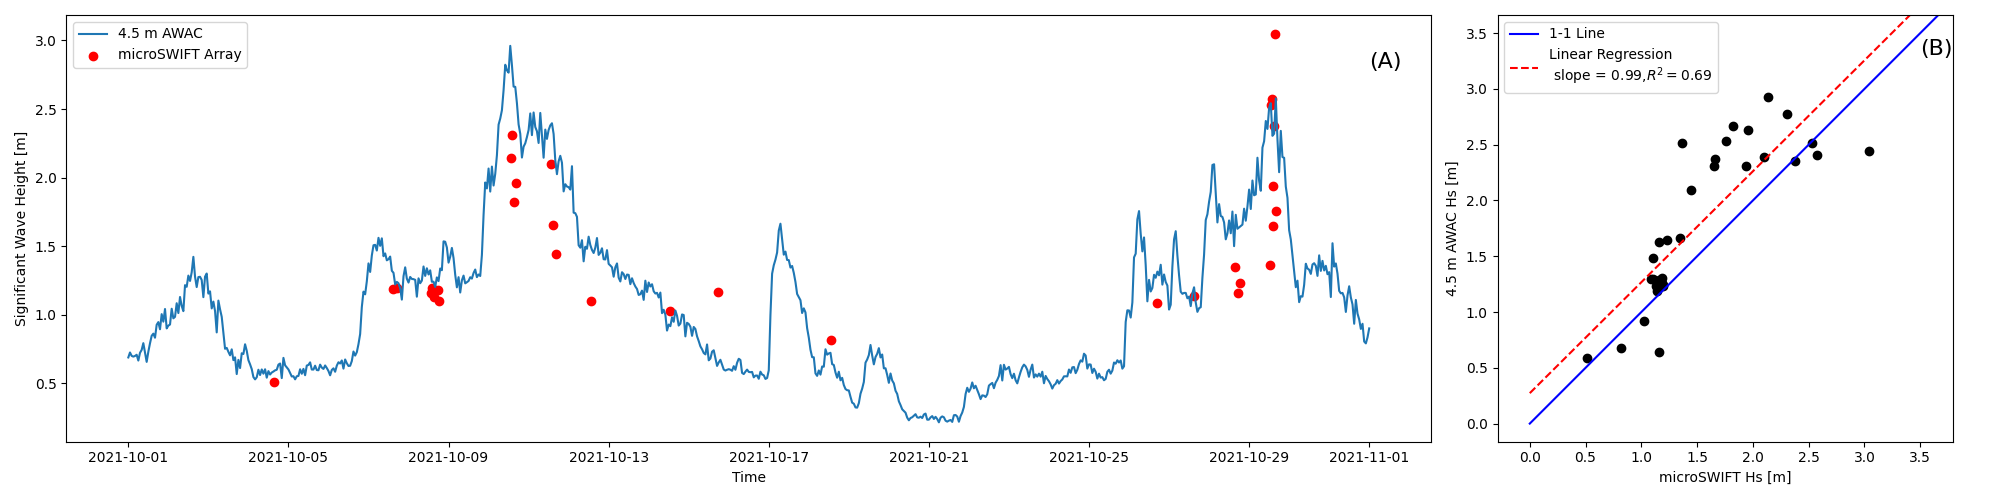

In [16]:
# Plot Hs as a function of time and compare to AWAC for further verification
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'], units=awac_data['time'].units, calendar=awac_data['time'].calendar)

# Compare the Significant wave heights between AWAC and microSWIFT arrays
mission_time_nums_45 = nc.date2num(mission_time_45, units=awac_data['time'].units, calendar=awac_data['time'].calendar)
awac_hs_interp_45 = np.interp(mission_time_nums_45, awac_data['time'][:], awac_data['waveHs'][:])

# Compute linear regression between the AWAC and microSWIFT Hs
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Hs_45, awac_hs_interp_45)

# Plot the AWAC and microSWIFT Hs values
fig_hs, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2, gridspec_kw={'width_ratios': [3, 1]})
# Time series
ax1.scatter(mission_time_45, Hs_45, color='r', label='microSWIFT Array')
ax1.plot(awac_time, awac_data['waveHs'][:], label='4.5 m AWAC')
ax1.set_xlabel('Time')
ax1.set_ylabel('Significant Wave Height [m]')
ax1.annotate('(A)', (awac_time[-1], 2.8), color='k', fontsize=16)
ax1.legend()

# Scatter plot
ax2.scatter(Hs_45, awac_hs_interp_45, color='k')
ax2.set_xlabel('microSWIFT Hs [m]')
ax2.set_ylabel('4.5 m AWAC Hs [m]')
ax2.axis('equal')
x = np.linspace(0, 4.5)
y = slope * x + intercept
ax2.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax2.plot(x, y, 
         color='r',
         linestyle='dashed',
         label='Linear Regression \n slope = {0:.2f},$R^2 = {1:.2f}$'.format(slope, r_value**2))
ax2.annotate('(B)', (3.5, 3.3), color='k', fontsize=16)
ax2.set_xlim(0,3.5)
ax2.set_ylim(0,3.5)
ax2.legend()
fig_hs.tight_layout()
fig_hs.savefig('./Figures/Hs_comparison_45.png')

Text(0, 0.5, 'Along Shore Location, y [m]')

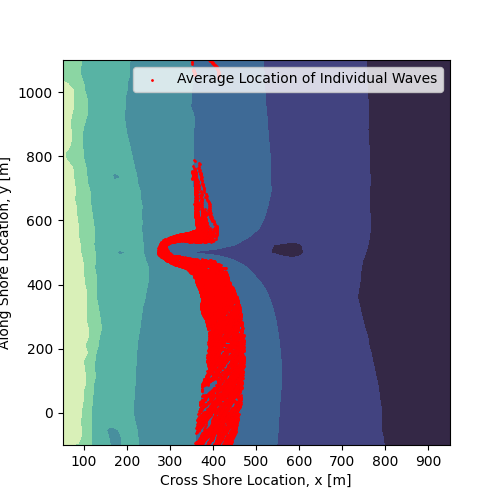

In [8]:
# Plot the Location of all validation waves
fig, ax = plt.subplots(figsize=(5,5))
# Plot Average Location of Each Wave on Bathymetry
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
im =ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap=cmocean.cm.deep_r)
cbar_bathy = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, location='top', orientation='horizontal')
cbar_bathy.ax.set_xlabel('Elevation, z [m]')
ax.set_xlim([50, 950])
ax.set_ylim([-100, 1100])
ax.scatter(wave_x_locs_45, wave_y_locs_45, color='r', s=1, label='Average Location of Individual Waves')
ax.legend()
ax.set_xlabel('Cross Shore Location, x [m]')
ax.set_ylabel('Along Shore Location, y [m]')

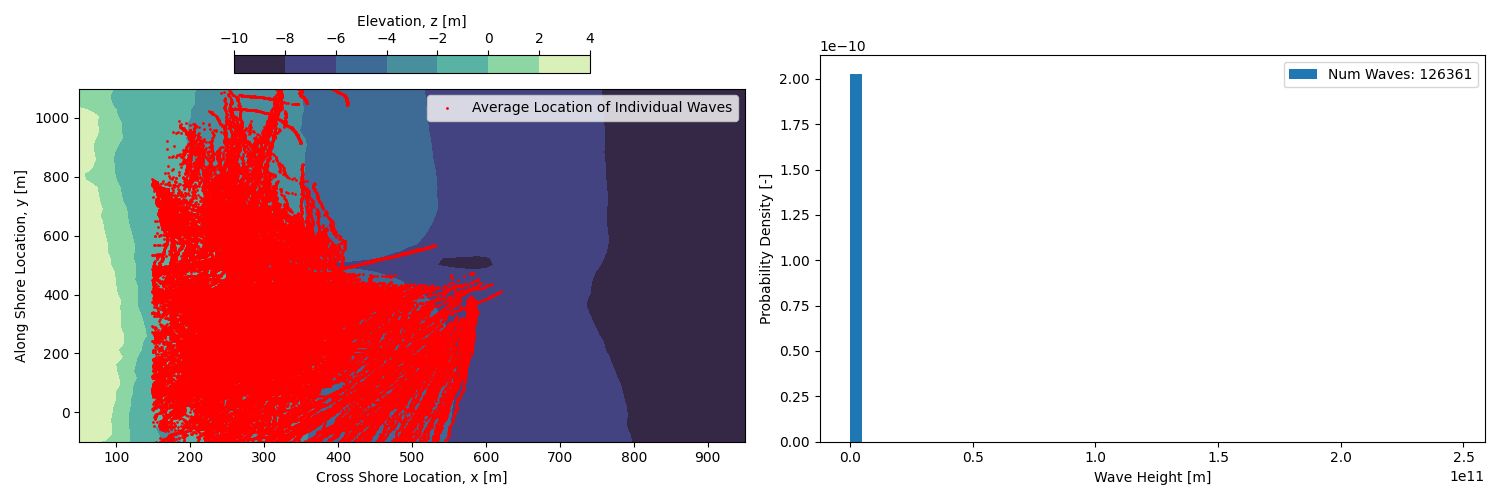

In [9]:
# Plot all smae as above but for all wave over the entire experiment
# Plot Distribution of Wave Heights 
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
# Plot Average Location of Each Wave on Bathymetry
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
im =ax1.contourf(xFRF_grid, yFRF_grid, bathy, cmap=cmocean.cm.deep_r)
cbar_bathy = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, location='top', orientation='horizontal')
cbar_bathy.ax.set_xlabel('Elevation, z [m]')
ax1.set_xlim([50, 950])
ax1.set_ylim([-100, 1100])
ax1.scatter(wave_x_locs_all, wave_y_locs_all, color='r', s=1, label='Average Location of Individual Waves')
ax1.legend()
ax1.set_xlabel('Cross Shore Location, x [m]')
ax1.set_ylabel('Along Shore Location, y [m]')

# Plot distribution of Wave Heights
ax2.hist(wave_heights_all, bins=50, density=True, label='Num Waves: {0:.0f}'.format(len(wave_heights_all)))
ax2.set_xlabel('Wave Height [m]')
ax2.set_ylabel('Probability Density [-]')
ax2.legend()

# # Plot Normalized Wave Height versus cross shore location
# x = wave_x_locs_norm_all
# y = wave_height_norm_all
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# z = z/z.size
# #     idx = z.argsort()
# #     x, y, z = x[idx], y[idx], z[idx]
# scatter = ax3.scatter(x, y, c=z, cmap='plasma')
# cbar_dense = fig.colorbar(scatter, ax=ax3)
# cbar_dense.ax.set_ylabel('Probability Density')
# ax3.hlines(y=np.nanmean(wave_height_norm_all), xmin=0, xmax=1, linewidth=2, color='r', label='Average H/d: {0:.2f}'.format(np.nanmean(wave_height_norm_all)))
# ax3.set_xlabel('Normalized Cross Shore Distance, x/$L_{sz}$ [-]')
# ax3.set_ylabel('Depth Normalized Wave Height,H/d [-]')
# ax3.legend()

# Save the Figure 
fig.tight_layout()
fig.savefig('./Figures/processedWaves_all.png')

